In [1]:
import mlrun
# get/create a project and register the data prep and trainer function in it
project = mlrun.get_or_create_project(
    name="ny-taxi-batch-demo", user_project=True, context="./"
)

> 2022-11-17 16:12:15,679 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 16:12:15,681 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 16:12:15,738 [info] loaded project ny-taxi-batch-demo from MLRun DB


In [2]:
project.set_function('src/data_prep.py', 'data-prep', image='mlrun/ml-models',
                     handler='data_preparation', kind="job")
project.set_function('src/trainer.py', 'trainer', image='mlrun/ml-models',
                     handler='train', kind="job")
project.save()

In [3]:
# execute the function through MLRun SDK (can run locally or over the k8s cluster)
data_prep = project.run_function("data-prep", inputs={"dataset": "./data/dataset.csv"}, local=True)

# get the returned data artifact
train_dataset = data_prep.artifact("train_dataset").as_df()
train_dataset.head()

> 2022-11-17 16:12:16,116 [info] starting run data-prep-data_preparation uid=2e4262d203ca4ce98b4ec26936433bf6 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ny-taxi-batch-demo-davesh,...36433bf6,0,Nov 17 16:12:16,completed,data-prep-data_preparation,v3io_user=Daveshkind=owner=Daveshhost=jupyter-davids-55f4d7f589-bm7n5,dataset,,label_column=fare_amount,train_datasettest_dataset


> 2022-11-17 16:12:23,454 [info] run executed, status=completed


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,bearing,distance,timestamp_hour,timestamp_day,timestamp_month,timestamp_weekday,timestamp_year
20427,4.5,-1.291285,0.711280,-1.291174,0.711358,2,42.861926,34.437829,19.048722,18.134339,10.087763,-0.957564,0.015063,13,19,8,2,2009
7664,4.5,-1.291418,0.711095,-1.291643,0.711194,1,43.984981,30.908201,22.482511,14.729460,7.185111,1.155810,0.027264,21,26,1,3,2012
26381,8.0,-1.291333,0.711110,-1.291667,0.710975,1,43.082942,30.694289,22.635516,13.772096,6.034810,1.954425,0.040039,14,16,10,1,2012
32076,9.5,-1.291636,0.710672,-1.291784,0.710387,3,41.996587,27.164881,27.477214,7.605850,1.964185,2.664129,0.035726,12,24,12,0,2012
29797,4.9,-1.291105,0.711330,-1.291243,0.711106,1,41.688729,34.447022,18.940218,17.439794,9.181444,2.588475,0.029304,9,14,2,1,2012


In [4]:
# execute the function through MLRun SDK (can run locally or over the k8s cluster)
train = project.run_function("trainer",
                             inputs={"train_set": data_prep.outputs["train_dataset"]})

# print the results of the training run
train.outputs

> 2022-11-17 16:12:23,665 [info] starting run trainer-train uid=a45109af3f6a422cb2e06f13393ff6a6 DB=http://mlrun-api:8080
> 2022-11-17 16:12:23,885 [info] Job is running in the background, pod: trainer-train-bp2mc
> 2022-11-17 16:16:32,377 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ny-taxi-batch-demo-davesh,...393ff6a6,0,Nov 17 16:12:30,completed,trainer-train,v3io_user=Daveshkind=jobowner=Daveshmlrun/client_version=1.2.0-rc10host=trainer-train-bp2mc,train_set,,mean_absolute_error=1.8508432550095957r2_score=0.6904810423762897root_mean_squared_error=5.750749501097406mean_squared_error=33.07111982437207,feature-importancetest_setmodel


> 2022-11-17 16:16:37,143 [info] run executed, status=completed


{'mean_absolute_error': 1.8508432550095957,
 'r2_score': 0.6904810423762897,
 'root_mean_squared_error': 5.750749501097406,
 'mean_squared_error': 33.07111982437207,
 'feature-importance': 'v3io:///projects/ny-taxi-batch-demo-davesh/artifacts/trainer-train/0/feature-importance.html',
 'test_set': 'store://artifacts/ny-taxi-batch-demo-davesh/trainer-train_test_set:a45109af3f6a422cb2e06f13393ff6a6',
 'model': 'store://artifacts/ny-taxi-batch-demo-davesh/lgbm_ny_taxi:a45109af3f6a422cb2e06f13393ff6a6'}

In [5]:
# Register the workflow file:
workflow_name = "lgbm_ny_taxi_pipeline_batch_predict"
project.set_workflow(workflow_name, "src/workflow-batch.py")

# Save the project:
project.save()

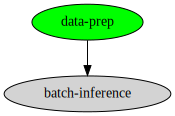

In [ ]:
workflow_run = project.run(
    name=workflow_name,
    arguments={
        "batch": "https://s3.us-east-1.wasabisys.com/iguazio/data/nyc-taxi/test.csv",
        "model": str(train.outputs["model"]),
    },
    watch=True,
)

In [ ]:
project.get_artifact('batch-inference_drift_table_plot').to_dataitem().show()
